# Exploration du Dataset COVID-19 - Radiographies Thoraciques

Ce notebook présente l'exploration initiale du dataset de radiographies thoraciques pour la détection du COVID-19.

## Objectifs
1. Charger et comprendre la structure du dataset Kaggle
2. Analyser la distribution des classes
3. Visualiser des exemples d'images
4. Identifier les caractéristiques clés des données
5. Détecter les éventuels problèmes (déséquilibre, qualité des images, etc.)

## 1. Importation des bibliothèques

In [12]:
# Manipulation de données
import numpy as np
import pandas as pd
import os
from pathlib import Path

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Traitement d'images
from PIL import Image
import cv2

# Kaggle pour le téléchargement du dataset
import kagglehub

# Configuration de l'affichage
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Ignorer les avertissements
import warnings
warnings.filterwarnings('ignore')

print("Bibliothèques importées avec succès!")

Bibliothèques importées avec succès!


## 2. Téléchargement automatique du dataset

Nous allons utiliser `kagglehub` pour télécharger automatiquement le dataset **COVID-19 Radiography Database**.

Ce dataset contient:
- **COVID**: 3616 images de patients COVID-19
- **Normal**: 10192 images de patients sains
- **Viral Pneumonia**: 1345 images de pneumonie virale
- **Lung Opacity**: 6012 images d'opacité pulmonaire

**Note**: Le dataset sera téléchargé dans un cache local et accessible via le chemin retourné.

In [13]:
# Télécharger le dataset COVID-19 Radiography Database
print("📥 Téléchargement du dataset COVID-19 Radiography Database...")
print("Cela peut prendre quelques minutes selon votre connexion.")

try:
    # Télécharger le dataset
    dataset_path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")
    
    print(f"✅ Dataset téléchargé avec succès!")
    print(f"📁 Emplacement: {dataset_path}")
    
    # Définir le chemin vers les images
    DATA_PATH = Path(dataset_path) / "COVID-19_Radiography_Dataset"
    
    if DATA_PATH.exists():
        print(f"✓ Dossier des images trouvé: {DATA_PATH}")
        print(f"\n📂 Contenu du dossier:")
        for item in sorted(DATA_PATH.iterdir()):
            if item.is_dir():
                print(f"  📁 {item.name}/")
            else:
                print(f"  📄 {item.name}")
    else:
        print(f"⚠️ Le dossier des images n'est pas à l'emplacement attendu.")
        print(f"Recherche dans le dossier téléchargé...")
        for root, dirs, files in os.walk(dataset_path):
            if any(d.lower() in ['covid', 'normal', 'pneumonia'] for d in dirs):
                DATA_PATH = Path(root)
                print(f"✓ Dossier des images trouvé: {DATA_PATH}")
                break
        
except Exception as e:
    print(f"❌ Erreur lors du téléchargement: {e}")
    print("\n🔄 Alternative: Utiliser le chemin local si vous avez déjà le dataset")
    DATA_PATH = Path('../data/raw')  # Fallback vers chemin local
    if not DATA_PATH.exists():
        print(f"✗ Le dossier {DATA_PATH} n'existe pas.")
        print("Veuillez télécharger manuellement le dataset ou vérifier votre connexion.")

📥 Téléchargement du dataset COVID-19 Radiography Database...
Cela peut prendre quelques minutes selon votre connexion.
✅ Dataset téléchargé avec succès!
📁 Emplacement: /Users/theodaguier/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5
✓ Dossier des images trouvé: /Users/theodaguier/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5/COVID-19_Radiography_Dataset

📂 Contenu du dossier:
  📁 COVID/
  📄 COVID.metadata.xlsx
  📁 Lung_Opacity/
  📄 Lung_Opacity.metadata.xlsx
  📁 Normal/
  📄 Normal.metadata.xlsx
  📄 README.md.txt
  📁 Viral Pneumonia/
  📄 Viral Pneumonia.metadata.xlsx


## 3. Exploration de la structure du dataset

In [14]:
# Fonction pour explorer la structure des dossiers
def explore_directory_structure(path, max_depth=3, current_depth=0):
    """
    Explore et affiche la structure des dossiers du dataset
    """
    if not path.exists() or current_depth >= max_depth:
        return
    
    indent = "  " * current_depth
    
    if path.is_dir():
        items = list(path.iterdir())
        print(f"{indent}{path.name}/ ({len(items)} items)")
        
        for item in sorted(items):
            if item.is_dir():
                explore_directory_structure(item, max_depth, current_depth + 1)
            else:
                print(f"{indent}  - {item.name}")

if DATA_PATH.exists():
    explore_directory_structure(DATA_PATH)

COVID-19_Radiography_Dataset/ (9 items)
  COVID/ (2 items)
    images/ (3616 items)
      - COVID-1.png
      - COVID-10.png
      - COVID-100.png
      - COVID-1000.png
      - COVID-1001.png
      - COVID-1002.png
      - COVID-1003.png
      - COVID-1004.png
      - COVID-1005.png
      - COVID-1006.png
      - COVID-1007.png
      - COVID-1008.png
      - COVID-1009.png
      - COVID-101.png
      - COVID-1010.png
      - COVID-1011.png
      - COVID-1012.png
      - COVID-1013.png
      - COVID-1014.png
      - COVID-1015.png
      - COVID-1016.png
      - COVID-1017.png
      - COVID-1018.png
      - COVID-1019.png
      - COVID-102.png
      - COVID-1020.png
      - COVID-1021.png
      - COVID-1022.png
      - COVID-1023.png
      - COVID-1024.png
      - COVID-1025.png
      - COVID-1026.png
      - COVID-1027.png
      - COVID-1028.png
      - COVID-1029.png
      - COVID-103.png
      - COVID-1030.png
      - COVID-1031.png
      - COVID-1032.png
      - COVID-1033.png
     

## 4. Analyse de la distribution des classes

In [15]:
# Compter les images par classe
IMAGE_EXTENSIONS = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'}

def count_images_by_class(base_path):
    """Compte le nombre d'images dans chaque classe (sous-dossier ou dossier images/)"""
    class_counts = {}

    if not base_path.exists():
        print(f"❌ Le chemin {base_path} n'existe pas.")
        return class_counts

    for class_dir in sorted(base_path.iterdir()):
        if not class_dir.is_dir():
            continue

        search_root = class_dir / 'images'
        if not search_root.is_dir():
            search_root = class_dir

        image_count = sum(
            1
            for file in search_root.rglob('*')
            if file.is_file() and file.suffix.lower() in IMAGE_EXTENSIONS
        )
        class_counts[class_dir.name] = image_count

    return class_counts

class_distribution = {}

if DATA_PATH.exists():
    class_distribution = count_images_by_class(DATA_PATH)

    if class_distribution:
        print("\nDistribution des classes:")
        print('-' * 40)
        total = sum(class_distribution.values())

        for class_name, count in sorted(class_distribution.items()):
            percentage = (count / total * 100) if total > 0 else 0
            print(f"{class_name:20} : {count:6} images ({percentage:5.2f}%)")

        print('-' * 40)
        print(f"{'TOTAL':20} : {total:6} images")
    else:
        print("⚠️ Aucun dossier de classe contenant des images n'a été trouvé dans DATA_PATH.")
else:
    print(f"⚠️ DATA_PATH ({DATA_PATH}) n'existe pas encore. Téléchargez ou pointez vers le dossier des images.")




Distribution des classes:
----------------------------------------
COVID                :   3616 images (17.08%)
Lung_Opacity         :   6012 images (28.41%)
Normal               :  10192 images (48.15%)
Viral Pneumonia      :   1345 images ( 6.35%)
----------------------------------------
TOTAL                :  21165 images


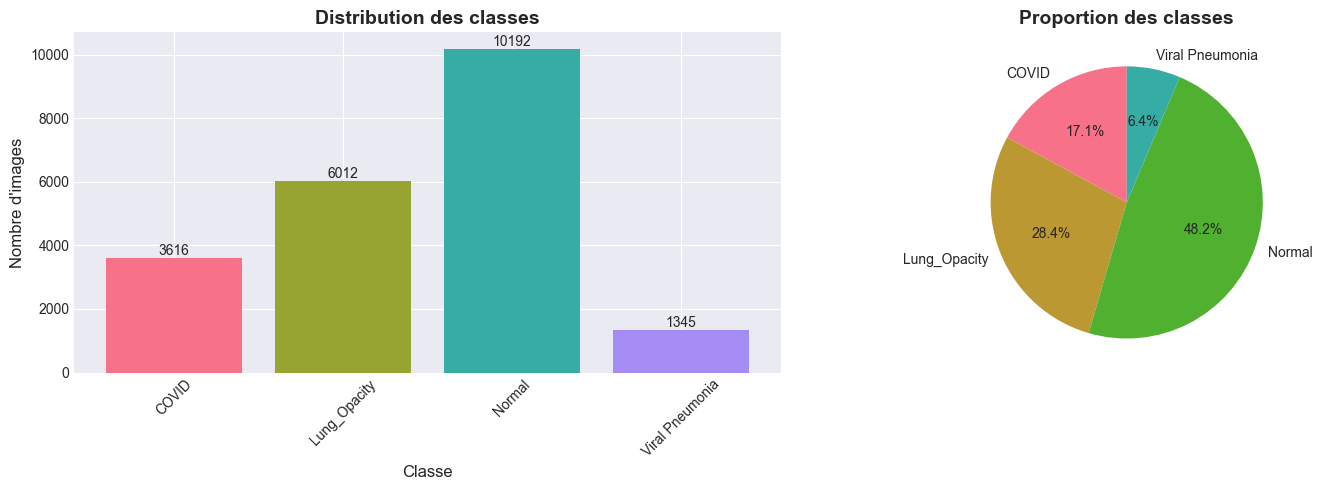


📊 Analyse du déséquilibre:
  Ratio de déséquilibre: 7.58:1
  ⚠️  Dataset fortement déséquilibré - considérer des techniques d'équilibrage


In [16]:
# Visualisation de la distribution
if DATA_PATH.exists() and class_distribution:
    classes = list(class_distribution.keys())
    counts = list(class_distribution.values())
    total = sum(counts)

    if total == 0:
        print("⚠️ Les dossiers ont été trouvés mais aucune image exploitable n'est disponible.")
    else:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Graphique en barres
        ax1.bar(classes, counts, color=sns.color_palette('husl', len(classes)))
        ax1.set_xlabel('Classe', fontsize=12)
        ax1.set_ylabel("Nombre d'images", fontsize=12)
        ax1.set_title('Distribution des classes', fontsize=14, fontweight='bold')
        ax1.tick_params(axis='x', rotation=45)

        for i, (class_name, count) in enumerate(zip(classes, counts)):
            ax1.text(i, count, str(count), ha='center', va='bottom')

        # Graphique circulaire
        ax2.pie(counts, labels=classes, autopct='%1.1f%%', startangle=90)
        ax2.set_title('Proportion des classes', fontsize=14, fontweight='bold')

        plt.tight_layout()
        plt.show()

        max_count = max(counts)
        min_count = min(counts)
        print("\n📊 Analyse du déséquilibre:")
        if min_count == 0:
            print("  ⚠️ Impossible de calculer un ratio car au moins une classe est vide.")
        else:
            imbalance_ratio = max_count / min_count
            print(f"  Ratio de déséquilibre: {imbalance_ratio:.2f}:1")
            if imbalance_ratio > 3:
                print("  ⚠️  Dataset fortement déséquilibré - considérer des techniques d'équilibrage")
            elif imbalance_ratio > 1.5:
                print("  ⚡ Dataset modérément déséquilibré")
            else:
                print("  ✓ Dataset relativement équilibré")
elif not DATA_PATH.exists():
    print("⚠️ Impossible d'afficher la distribution: DATA_PATH est introuvable.")
else:
    print("⚠️ Impossible d'afficher la distribution: aucune classe détectée.")



## 5. Aperçu visuel de 100 images

Nous affichons un échantillon aléatoire de 100 radiographies arrangées dans une grille 10x10 pour contrôler rapidement la diversité du dataset.

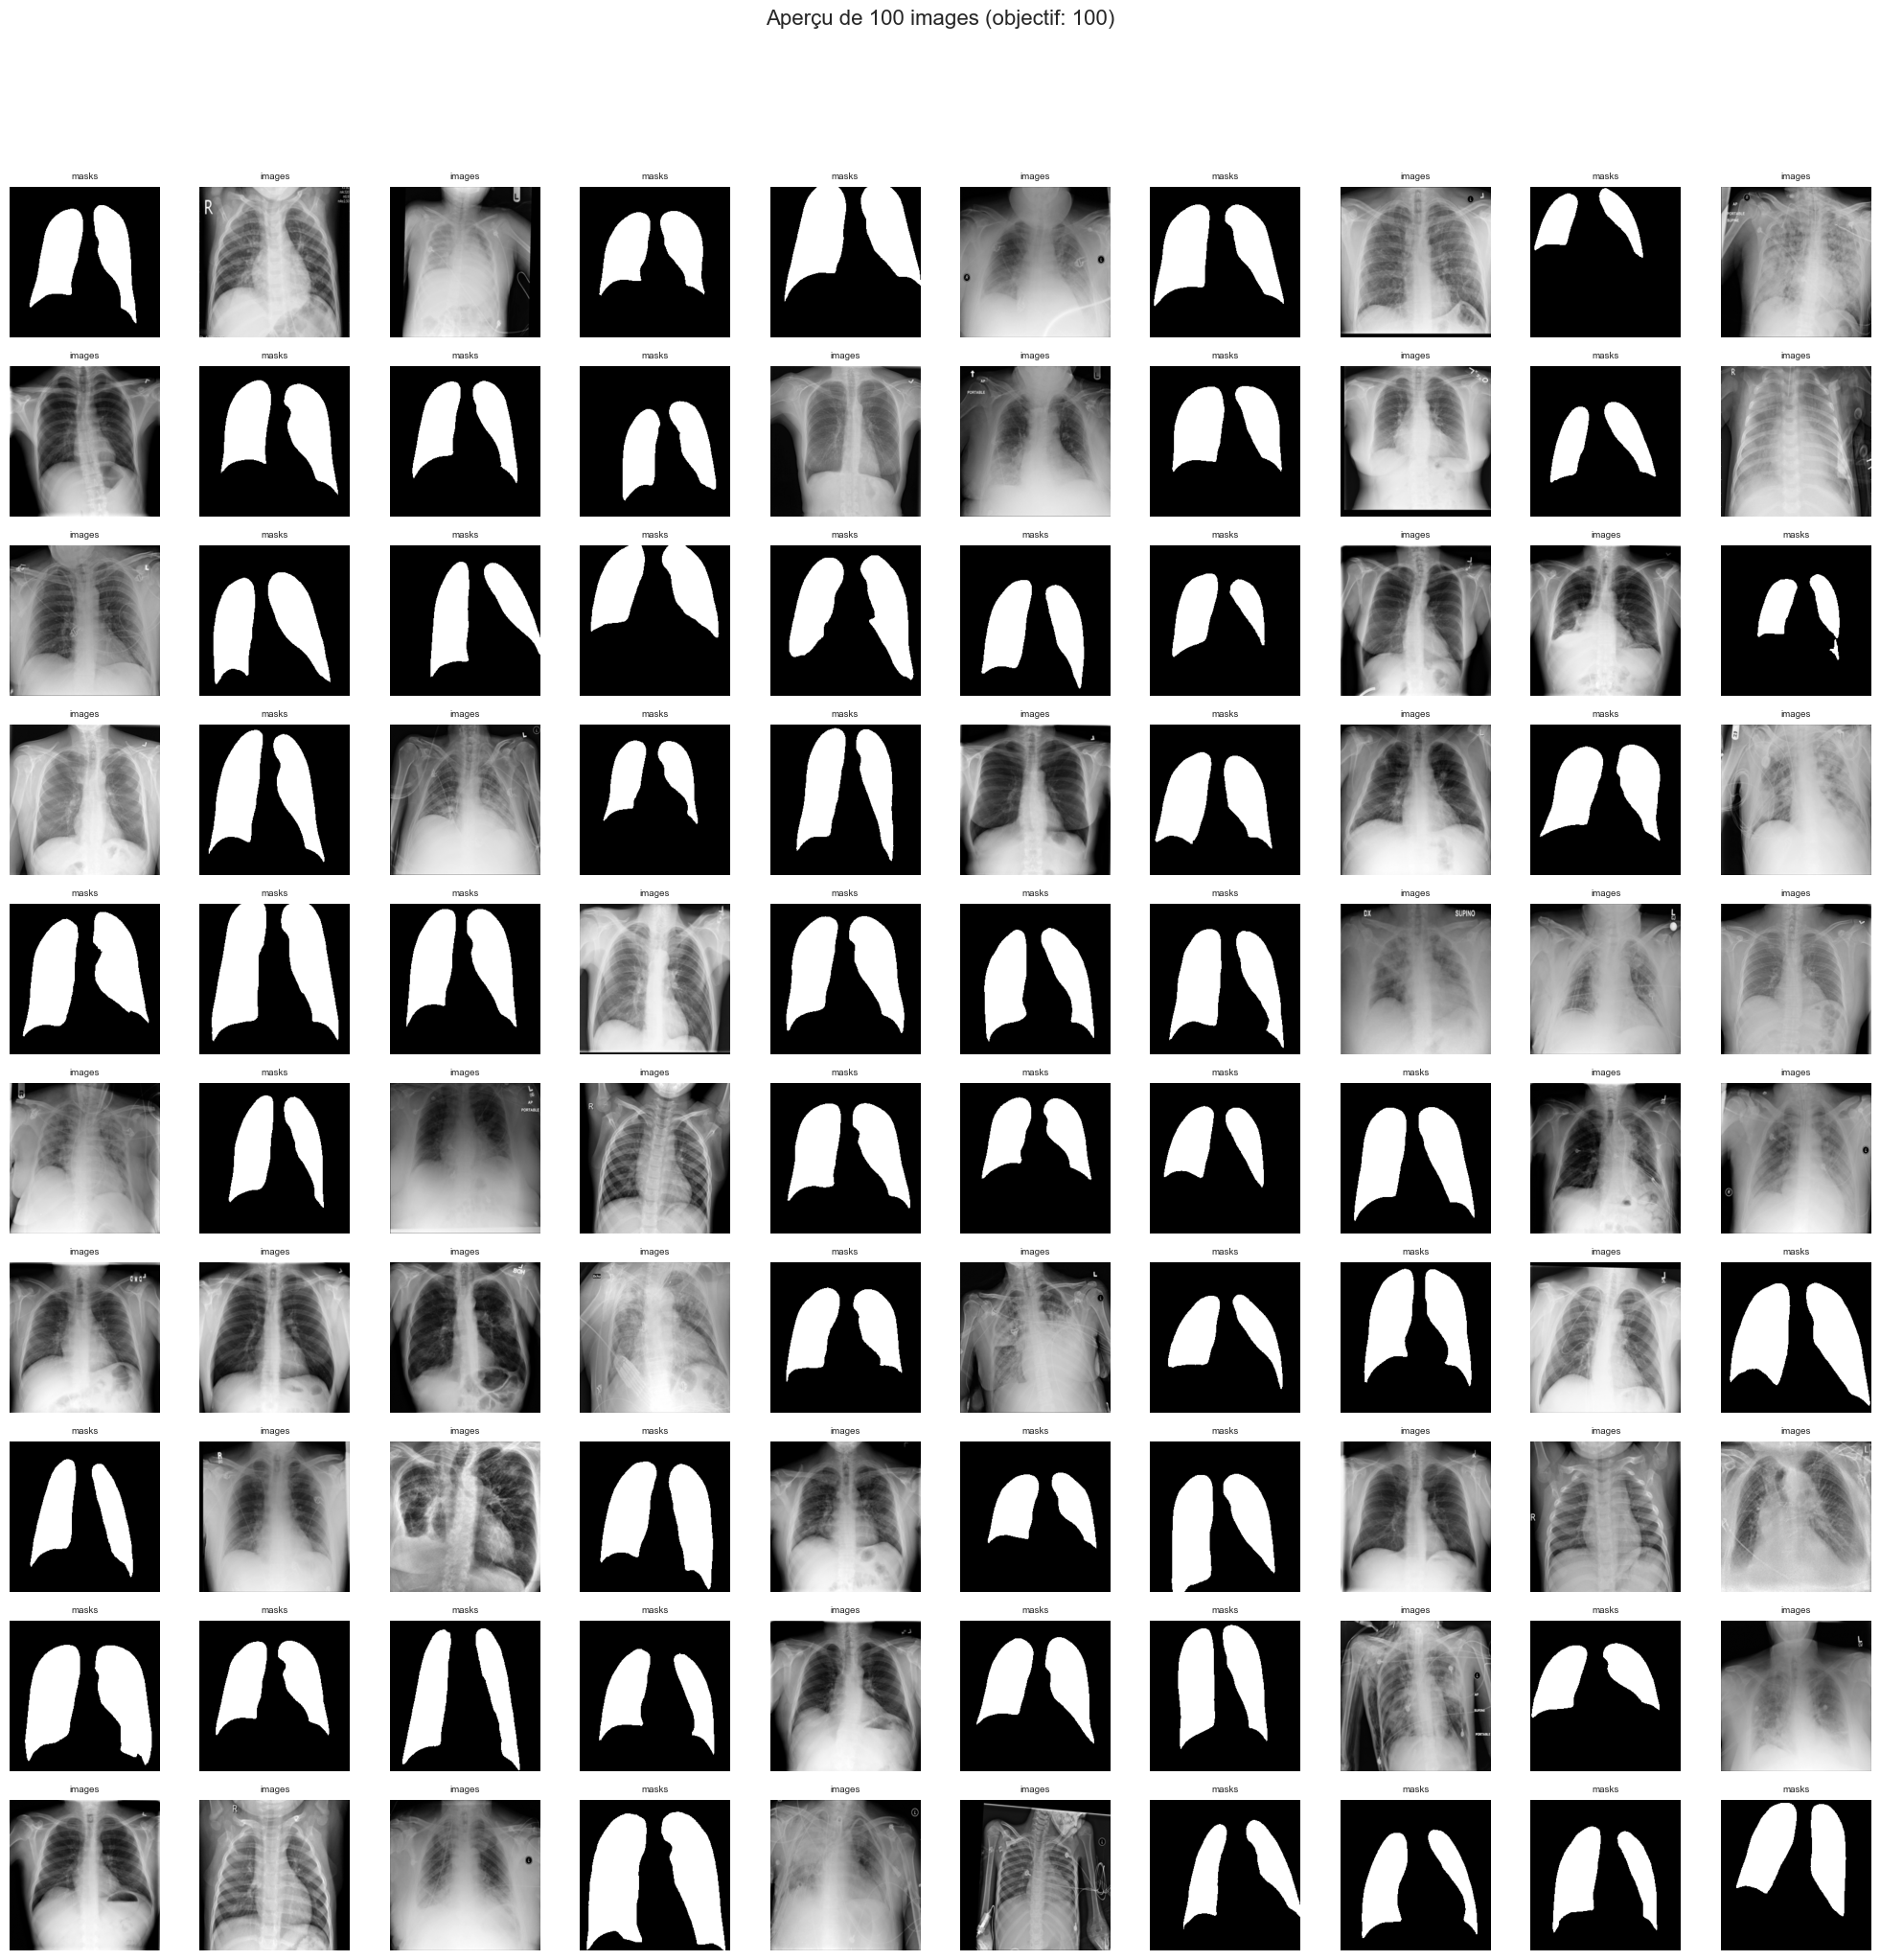

In [17]:
# Aperçu visuel de 100 images dans une grille carrée
def preview_image_grid(base_path, n_images=100, seed=42):
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'}
    if not base_path.exists():
        print(f'⚠️ DATA_PATH introuvable: {base_path}')
        return
    all_images = [p for p in base_path.rglob('*') if p.suffix.lower() in image_extensions]
    if not all_images:
        print('⚠️ Aucun fichier image trouvé dans DATA_PATH.')
        return
    rng = np.random.default_rng(seed)
    n_available = len(all_images)
    n_to_show = min(n_images, n_available)
    grid_base = n_images if n_available >= n_images else n_to_show
    grid_size = int(np.ceil(np.sqrt(grid_base)))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size * 2, grid_size * 2))
    axes = np.array(axes).reshape(-1)
    for ax in axes:
        ax.axis('off')
    for ax, img_path in zip(axes, rng.choice(all_images, size=n_to_show, replace=False)):
        try:
            with Image.open(img_path) as img:
                if img.mode not in ['RGB', 'RGBA']:
                    ax.imshow(img, cmap='gray')
                else:
                    ax.imshow(img)
            ax.set_title(img_path.parent.name, fontsize=7)
        except Exception as exc:
            ax.set_title('Erreur de lecture', fontsize=7)
    fig.suptitle(f'Aperçu de {n_to_show} images (objectif: {n_images})', fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

preview_image_grid(DATA_PATH)


## 7. Analyse de la qualité des images

In [18]:
# Analyser la qualité et les statistiques des images
def analyze_image_quality(base_path, sample_size=50):
    """
    Analyse la qualité d'un échantillon d'images
    """
    stats = []
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'}
    
    if not base_path.exists():
        return pd.DataFrame()
    
    # Collecter toutes les images
    all_images = []
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if Path(file).suffix.lower() in image_extensions:
                all_images.append(Path(root) / file)
    
    sample = np.random.choice(all_images, min(sample_size, len(all_images)), replace=False)
    
    print(f"Analyse de {len(sample)} images pour la qualité...")
    
    for img_path in sample:
        try:
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                stats.append({
                    'mean_intensity': np.mean(img),
                    'std_intensity': np.std(img),
                    'min_intensity': np.min(img),
                    'max_intensity': np.max(img),
                    'contrast': np.max(img) - np.min(img)
                })
        except Exception as e:
            continue
    
    return pd.DataFrame(stats)

if DATA_PATH.exists():
    quality_df = analyze_image_quality(DATA_PATH, sample_size=50)
    
    if not quality_df.empty:
        print("\n💎 Statistiques de qualité des images:")
        print(quality_df.describe())

Analyse de 50 images pour la qualité...

💎 Statistiques de qualité des images:
       mean_intensity  std_intensity  min_intensity  max_intensity    contrast
count       50.000000      50.000000           50.0      50.000000   50.000000
mean        85.553503      87.719913            0.0     249.520000  249.520000
std         38.404462      27.974264            0.0      14.135265   14.135265
min         21.221466      32.607016            0.0     183.000000  183.000000
25%         55.885334      61.204412            0.0     255.000000  255.000000
50%         77.588310      96.207251            0.0     255.000000  255.000000
75%        115.086375     113.296312            0.0     255.000000  255.000000
max        164.203544     126.967387            0.0     255.000000  255.000000


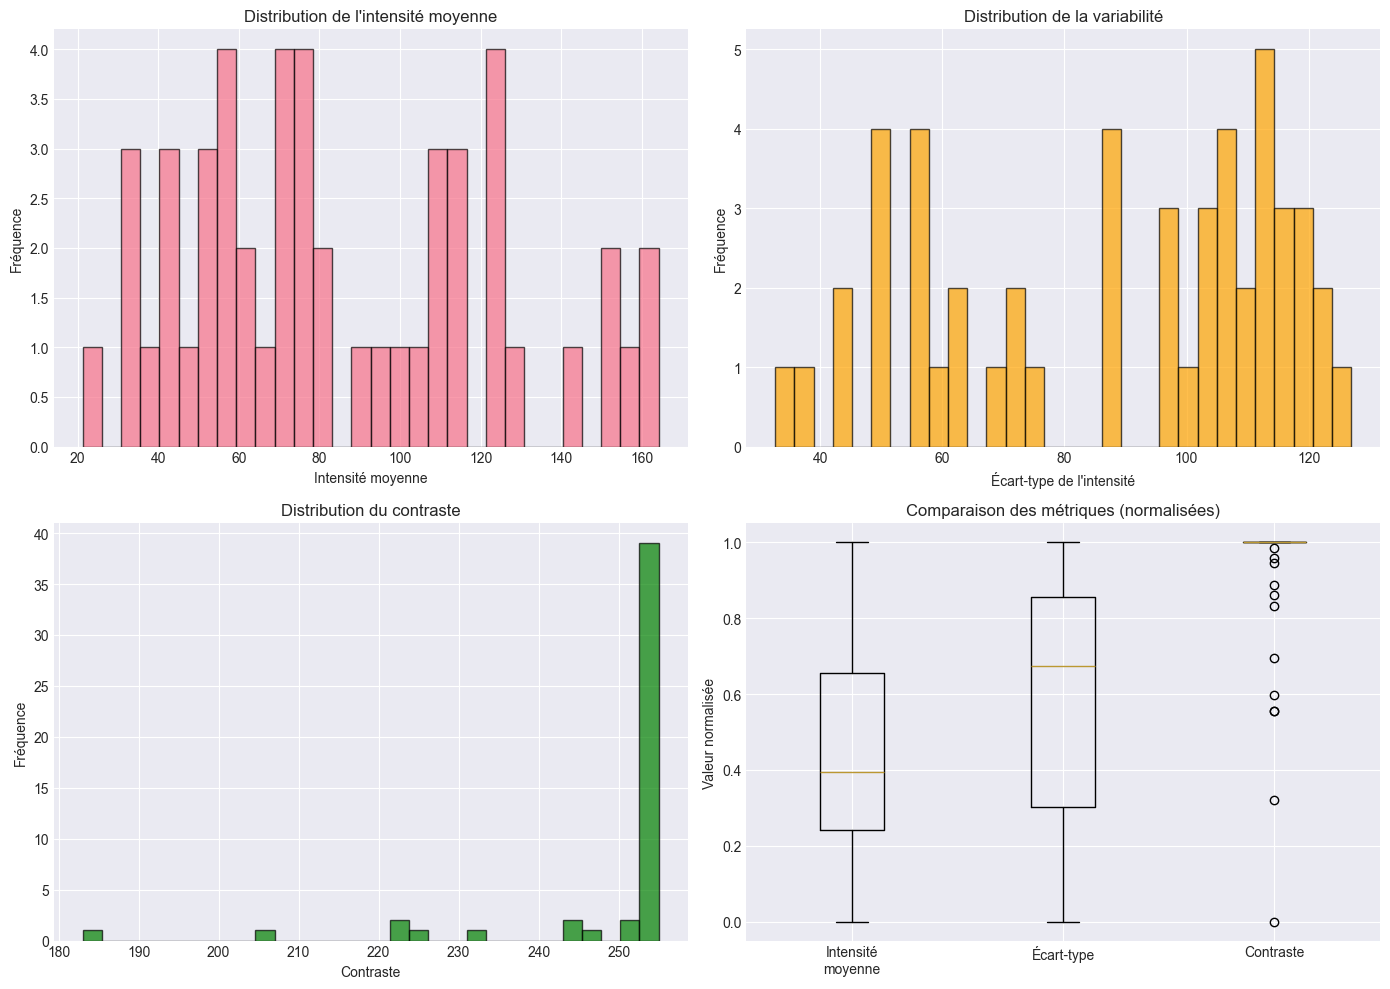

In [19]:
# Visualisation de la qualité
if DATA_PATH.exists() and not quality_df.empty:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Intensité moyenne
    axes[0, 0].hist(quality_df['mean_intensity'], bins=30, edgecolor='black', alpha=0.7)
    axes[0, 0].set_xlabel('Intensité moyenne')
    axes[0, 0].set_ylabel('Fréquence')
    axes[0, 0].set_title('Distribution de l\'intensité moyenne')
    
    # Écart-type de l'intensité
    axes[0, 1].hist(quality_df['std_intensity'], bins=30, edgecolor='black', alpha=0.7, color='orange')
    axes[0, 1].set_xlabel('Écart-type de l\'intensité')
    axes[0, 1].set_ylabel('Fréquence')
    axes[0, 1].set_title('Distribution de la variabilité')
    
    # Contraste
    axes[1, 0].hist(quality_df['contrast'], bins=30, edgecolor='black', alpha=0.7, color='green')
    axes[1, 0].set_xlabel('Contraste')
    axes[1, 0].set_ylabel('Fréquence')
    axes[1, 0].set_title('Distribution du contraste')
    
    # Boxplot comparatif
    quality_df_normalized = (quality_df - quality_df.min()) / (quality_df.max() - quality_df.min())
    axes[1, 1].boxplot([quality_df_normalized['mean_intensity'], 
                        quality_df_normalized['std_intensity'], 
                        quality_df_normalized['contrast']],
                       labels=['Intensité\nmoyenne', 'Écart-type', 'Contraste'])
    axes[1, 1].set_ylabel('Valeur normalisée')
    axes[1, 1].set_title('Comparaison des métriques (normalisées)')
    
    plt.tight_layout()
    plt.show()

## 9. Sauvegarde des résultats de l'exploration

In [20]:
# Créer un résumé des statistiques
if DATA_PATH.exists() and class_distribution:
    summary = {
        'dataset_path': str(DATA_PATH),
        'total_images': sum(class_distribution.values()),
        'n_classes': len(class_distribution),
        'class_distribution': class_distribution
    }
    
    if not dim_df.empty:
        summary['avg_width'] = dim_df['width'].mean()
        summary['avg_height'] = dim_df['height'].mean()
        summary['image_modes'] = dim_df['mode'].value_counts().to_dict()
    
    if not quality_df.empty:
        summary['avg_intensity'] = quality_df['mean_intensity'].mean()
        summary['avg_contrast'] = quality_df['contrast'].mean()
    
    print("\n" + "="*50)
    print("RÉSUMÉ DE L'EXPLORATION")
    print("="*50)
    for key, value in summary.items():
        print(f"{key}: {value}")
    print("="*50)


RÉSUMÉ DE L'EXPLORATION
dataset_path: /Users/theodaguier/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5/COVID-19_Radiography_Dataset
total_images: 21165
n_classes: 4
class_distribution: {'COVID': 3616, 'Lung_Opacity': 6012, 'Normal': 10192, 'Viral Pneumonia': 1345}
avg_width: 277.5
avg_height: 277.5
image_modes: {'RGB': 51, 'L': 49}
avg_intensity: 85.55350332982378
avg_contrast: 249.52
